##### Copyright 2024 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

# Data Preparation

### Step 1: Download a csv file of the embeddings using this [link](https://docs.google.com/forms/d/e/1FAIpQLSeZLIqTCIx1-OiBzUnqXZpu_k5M223ZvMmqwQhMZ_0TkaWhEQ/viewform)..

The county and ZCTA (zipcode census tabulation area) embeddings are available in different files.

Here we assume that you have obtained the embeddings and uploaded them to a Google Drive directory called `pdfm_embeddings/v0/us`.

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@markdown Specify the path to the embeddings folder.
BASE_PATH = '/content/drive/MyDrive/pdfm_embeddings/v0/us' #@param {type:"string"}

county_embeddings = pd.read_csv(BASE_PATH + 'county_embeddings.csv').set_index('place')
zip_embeddings = pd.read_csv(BASE_PATH + 'zcta_embeddings.csv').set_index('place')
embeddings = pd.concat([county_embeddings, zip_embeddings])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
embedding_features = [f'feature{x}' for x in range(330)]
embeddings.head(2)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,-0.059415,-0.165617,0.816348,-0.167234,2.099072,-0.168644,1.155944,1.620912,-0.089127,4.831956
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,-0.167371,0.049021,0.892724,-0.061048,2.791007,-0.166232,0.276117,2.892894,-0.128016,4.151655


### Step 2: Download and load a few variables from data commons.

In [ ]:
!pip install datacommons_pandas --upgrade --quiet
import datacommons_pandas as dc

In [ ]:
# This may take a few minutes to run.
labels = ['Count_Person',
          'Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
          'Median_Age_Person',
          'Median_Income_Household',
          'Percent_Person_WithAsthma',
          'Percent_Person_WithHighBloodPressure'
          ]
df_labels = dc.build_multivariate_dataframe(embeddings.index, labels)
print(df_labels.shape)
df_labels.head(2)

In [ ]:
df = embeddings.join(df_labels)
df.head(1)

In [ ]:
df['Percent_Person_WithHigherEdu'] = (df.Count_Person_EducationalAttainmentBachelorsDegreeOrHigher / df.Count_Person) * 100
df['county_id'] = df['county'] + df['state']

# Data Visualizations

## Download the county and zcta (Zipcode census tabulation area) level geojson file.

[link text](https://) The county and zcta level geojson file are available in the same folder as the embeddings. Download the geojson file into a local folder or a folder under Google drive. Here we assume that you have downloaded the file in Google Drive folder called pdfm_embeddings/v0/us

In [ ]:
import geopandas as gpd
county_geo = gpd.read_file(BASE_PATH + 'county.geojson')
zip_geo = gpd.read_file(BASE_PATH + 'zcta.geojson')

In [ ]:
geo = pd.concat([county_geo, zip_geo]).set_index('place')
embeddings = gpd.GeoDataFrame(embeddings, geometry=geo.geometry)
embeddings.shape

(35157, 336)

### Map out an embedding dimension spatially

In [ ]:
def get_locale(df, index, states=None, counties=None):
  df = df[df.index.isin(index)]
  if not states and not counties:
    return df
  filter = df.state.isin(states)
  if counties:
    filter &= df.county.isin(counties)
  return df[filter]

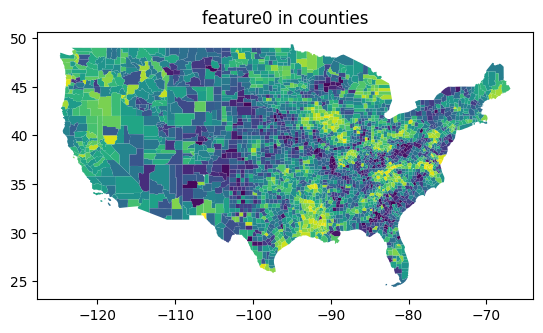

In [ ]:
#@title Map out an embedding dimension feature0 spatially across all counties in US
feature = embedding_features[0]
ax = get_locale(embeddings, county.index).plot(feature)
_ = ax.set_title(feature + ' in counties')

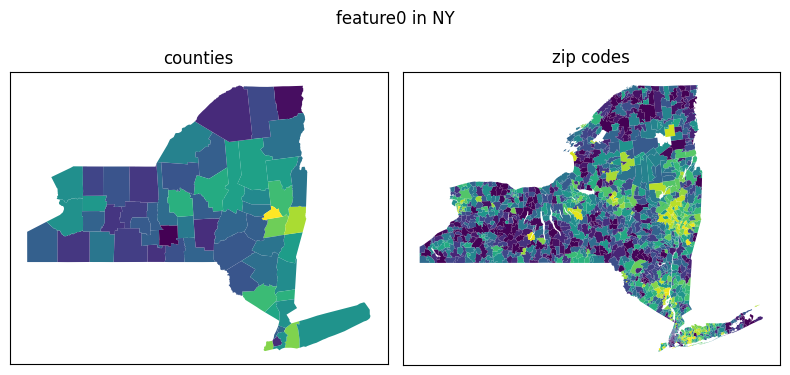

In [ ]:
#@title Map out an embedding dimension feature0 spatially across all counties and zipcodes in NY state
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
state = 'NY'
get_locale(embeddings, county_embeddings.index, states=[state]).plot(feature, ax=ax[0])
get_locale(embeddings, zip_embeddings.index, states=[state]).plot(feature, ax=ax[1])
fig.suptitle(f'{feature} in {state}')
ax[0].set(title='counties')
ax[1].set(title='zip codes')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

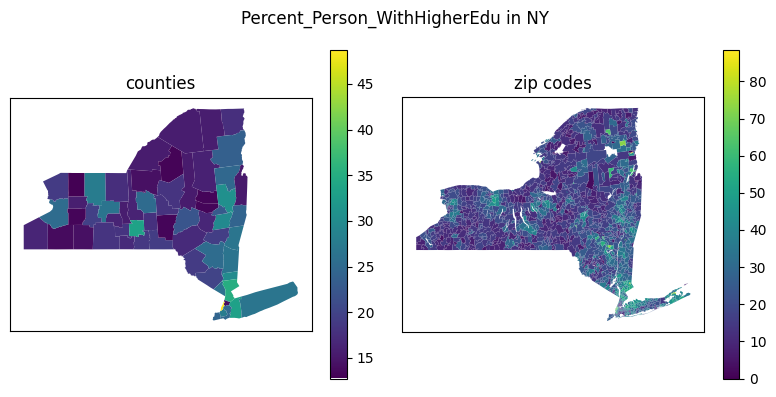

In [ ]:
#@title Map out a prediction variable spatially across all counties and zipcodes in NY state
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
feature = 'Percent_Person_WithHigherEdu'
state = 'NY'
get_locale(df, county_embeddings.index, states=[state]).plot(feature,
    legend=True, ax=ax[0])
get_locale(df, zip_embeddings.index, states=[state]).plot(feature,
    legend=True, ax=ax[1])
fig.suptitle(f'{feature} in {state}')
ax[0].set(title='counties')
ax[1].set(title='zip codes')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

# Applying the embeddings in a prediction task

In [ ]:
#@title Common imports and eval methods

def evaluate(df: pd.DataFrame) -> dict:
    """Evaluates the model performance on the given dataframe.

    Args:
        df: A pandas DataFrame with columns 'y' and 'y_pred'.

    Returns:
        A dictionary of performance metrics.
    """
    # Ensure necessary columns exist and drop rows with NaN or zero in 'y'
    if not {'y', 'y_pred'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'y' and 'y_pred' columns")

    df = df.dropna(subset=['y', 'y_pred'])
    df = df[df['y'] != 0]

    r2 = skmetrics.r2_score(df['y'], df['y_pred'])
    correlation = df['y'].corr(df['y_pred'])
    rmse = math.sqrt(skmetrics.mean_squared_error(df['y'], df['y_pred']))
    mae = skmetrics.mean_absolute_error(df['y'], df['y_pred'])
    mape = skmetrics.mean_absolute_percentage_error(df['y'], df['y_pred'])

    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape, 'correlation': correlation}


def subset_eval(label: str, county_name: str, state: str, gpred: gpd.GeoDataFrame,
                visualize: bool = True, cmap: str = 'Greys') -> dict:
    """Runs intra-county or intra-state evaluation and visualizes the results.

    Args:
        label: The label for the title of the visualization.
        county_name: The specific county name to filter.
        state: The specific state name to filter.
        gpred: GeoDataFrame containing 'y', 'y_pred', 'state', and 'county' columns.
        visualize: Whether to display visualizations.
        cmap: Colormap for visualizations.

    Returns:
        A dictionary of performance metrics.
    """
    # Apply filters based on state and county name
    subset = gpred.copy()
    if state:
        subset = subset[subset['state'] == state]
    if county_name:
        subset = subset[subset['county'] == county_name]

    # Drop rows where 'y' is NaN
    subset = subset.dropna(subset=['y', 'y_pred'])
    eval_metrics = evaluate(subset)

    if visualize:
        _, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Scatter plot of predicted vs actual
        subset.plot.scatter('y', 'y_pred', alpha=0.8, ax=ax[2], color='darkgray')
        x0, x1 = subset[['y', 'y_pred']].min().min(), subset[['y', 'y_pred']].max().max()
        ax[2].plot([x0, x1], [x0, x1], ls='--', color='black')
        ax[2].set_title(f'r={eval_metrics["correlation"]:.2f}, mae={eval_metrics["mae"]:.2f}')

        # Maps of actual and predicted values
        subset.plot('y', legend=True, ax=ax[0], vmin=x0, vmax=x1, cmap=cmap,
                    legend_kwds={'fraction': 0.02, 'pad': 0.05})
        ax[0].set_title('Actual')
        subset.plot('y_pred', legend=False, ax=ax[1], vmin=x0, vmax=x1, cmap=cmap)
        ax[1].set_title('Predicted')

        plt.setp(ax[:2], xticks=[], yticks=[])
        plt.suptitle(f'{label} - {county_name}, {state}')
        plt.tight_layout()

    return eval_metrics


def make_predictions_df(predictions: np.ndarray, test_df: gpd.GeoDataFrame, label: str) -> gpd.GeoDataFrame:
    """Creates a GeoDataFrame with predictions, true labels, and geographic info.

    Args:
        predictions: A sequence of predictions.
        test_df: The original test GeoDataFrame that the predictions are based on.
        label: The column name for the true label in `test_df`.

    Returns:
        A GeoDataFrame for evaluation and visualizations.
    """
    if label not in test_df.columns:
        raise ValueError(f"The specified label '{label}' does not exist in test_df columns.")

    df_predictions = pd.DataFrame({'y': test_df[label], 'y_pred': predictions}, index=test_df.index)
    return test_df[['geometry', 'Count_Person', 'state', 'county']].join(df_predictions)


## Superresolution - Train the model on counties and make predictions for zip code.


In [ ]:
#@title Train on counties and predict for zip codes
label = 'Percent_Person_WithHigherEdu'
data = df[df[label].notna() & (df.population > 500)]
train = data[data.index.isin(county.index)]
test = data[data.index.isin(zip.index)]

model = linear_model.Ridge()
model.fit(train[embedding_features], train[label])
predictions = model.predict(test[embedding_features])
gdf_predictions = make_predictions_df(predictions, test)
evaluate(gdf_predictions)

{'r2': 0.7242757514645757,
 'rmse': 6.409256172323559,
 'mae': 4.413752906533899,
 'mape': 0.5268186207953971,
 'r': 0.85181678450501}

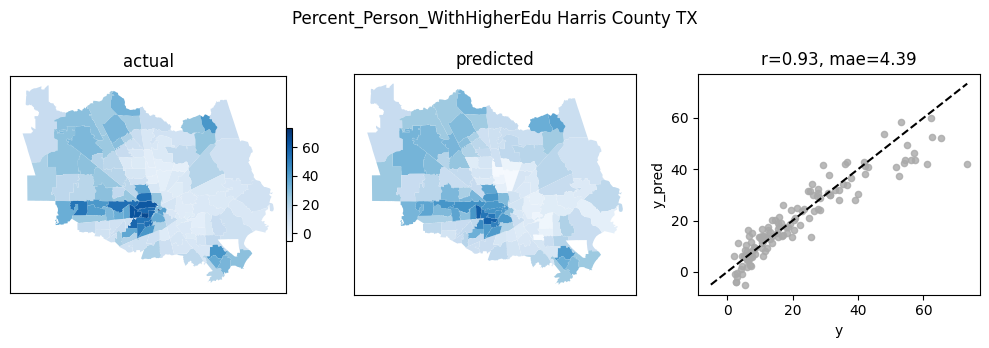

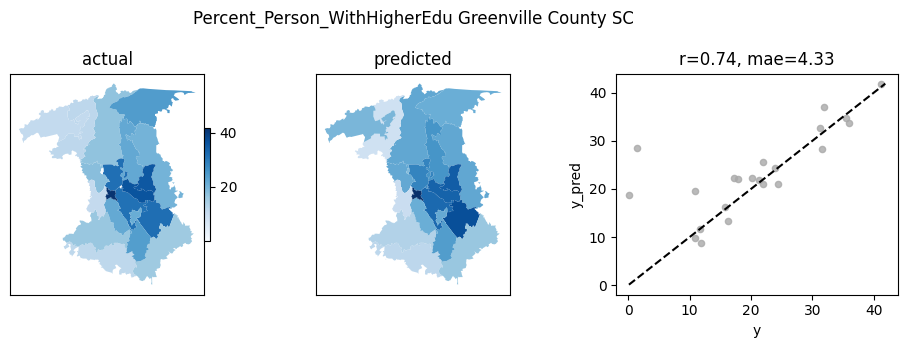

In [ ]:
#@title Visualize some test set predictions
_ = subset_eval(label, 'Harris County', 'TX', gdf_predictions, cmap='Blues')
_ = subset_eval(label, 'Greenville County', 'SC', gdf_predictions, cmap='Blues')

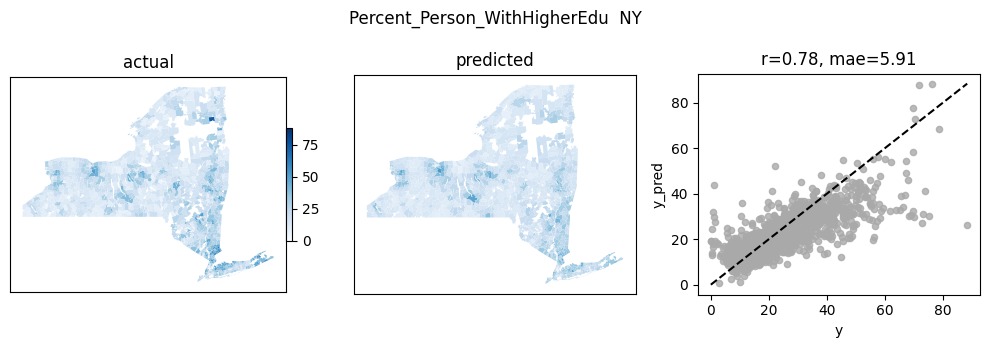

In [ ]:
#@title Evaluate over a state by setting the county to an empty string.
_ = subset_eval(label, '', 'NY', gdf_predictions, cmap='Blues')

## Imputation - zip -> zip
Train on zipcodes in a subset of counties.

In [ ]:
#@title train on zip codes in 20% of the counties, test on the remaining 80%.
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing

def get_train_test_split(training_fraction=0.8):
  data = df[df.index.isin(zip.index)].copy()
  # Split the zip codes by county into train/test sets.
  train_counties = data.drop_duplicates('county_id').sample(
      frac=training_fraction).county_id
  train = data[data.county_id.isin(train_counties)]
  test = data[~data.index.isin(train.index)]
  print('# training counties:', len(train_counties),
        '\n# training zip codes:', train.shape[0],
        '\n# test zip codes:', test.shape[0])
  return train, test

def run_imputation_model(
    train,
    test,
    label,
    min_population=500,
    model_class=linear_model.Ridge,
    model_kwargs={}):
  train = train[(train.population >= min_population) & train[label].notna()]
  test = test[(test.population >= min_population) & test[label].notna()]
  model = make_pipeline(preprocessing.MinMaxScaler(),
                        model_class(**model_kwargs))
  model.fit(train[embedding_features], train[label])
  predictions = model.predict(test[embedding_features])
  gdf_predictions = make_predictions_df(predictions, test)
  results = evaluate(gdf_predictions)
  return model, results


# Increasing this value generally improves performance.
training_fraction = 0.2
label = 'Percent_Person_WithHigherEdu'
train, test = get_train_test_split(training_fraction)
model, results = run_imputation_model(train, test, label)
results

# training counties: 618 
# training zip codes: 6522 
# test zip codes: 25547


{'r2': 0.7768492211327185,
 'rmse': 5.616825323055609,
 'mae': 3.9740700370991764,
 'mape': 0.41543763366689485,
 'r': 0.8827337576933226}

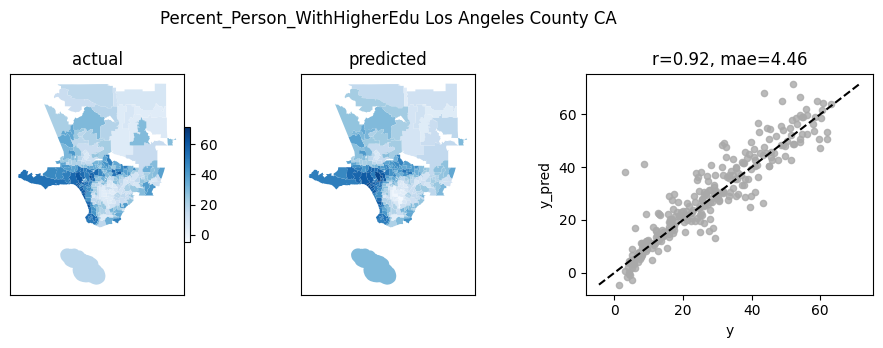

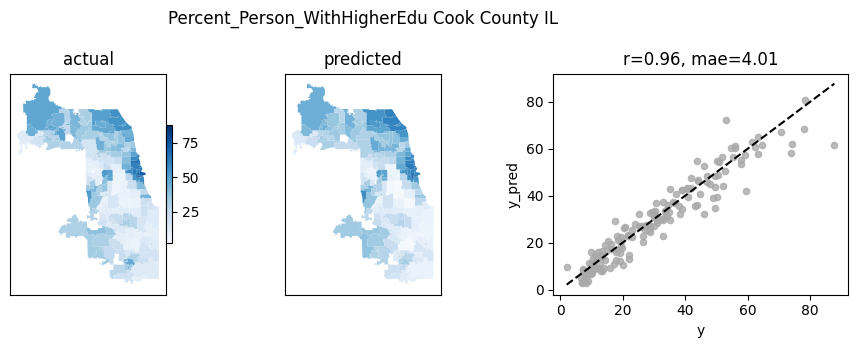

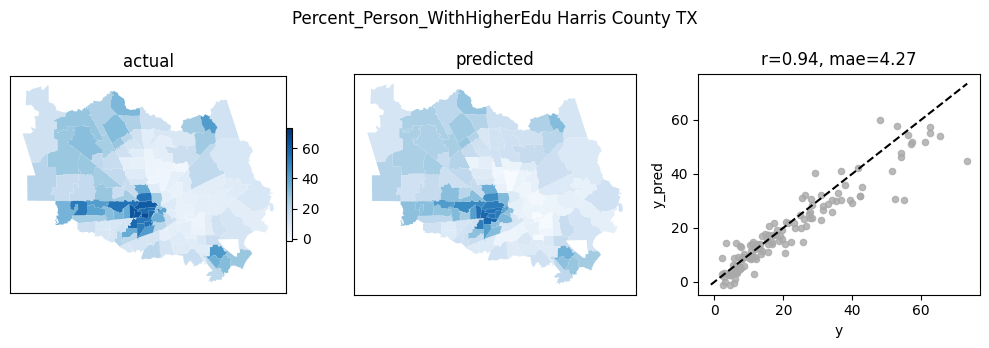

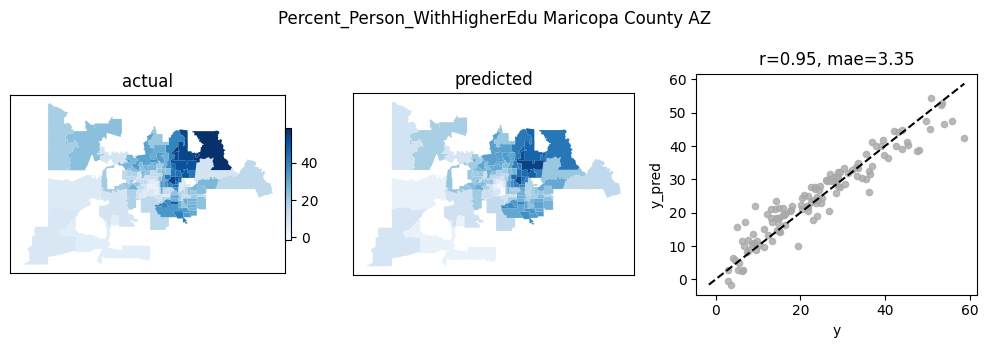

In [ ]:
#@title Visualize a few counties from the test set.
test_counties = test.county_id.unique()
large_counties = df[df.county_id.isin(test_counties)].sort_values(
    'population', ascending=False)[['state', 'county', 'population']].head(4)
for _, row in large_counties.iterrows():
  _ = subset_eval(label, row.county, row.state, gdf_predictions, cmap='Blues')

In [ ]:
#@title Try other labels.
labels = [
          'Percent_Person_WithHigherEdu',
          'Median_Age_Person',
          'Median_Income_Household',
          'Percent_Person_WithAsthma',
          'Percent_Person_WithHighBloodPressure'
]
train, test = get_train_test_split(0.8)
models_by_label = {}
metrics_df = pd.DataFrame(
    columns=['label', 'r2', 'rmse', 'mae', 'mape', 'model'])
for label in labels:
  models_by_label[label], results = run_imputation_model(train, test, label)
  results['label'] = label
  results['model'] = 'linear'
  metrics_df.loc[len(metrics_df)] = results

metrics_df.round(3)

# training counties: 2470 
# training zip codes: 25658 
# test zip codes: 6411


,label,r2,rmse,mae,mape,model
0,Percent_Person_WithHigherEdu,0.800,5.253,3.753,0.370,linear
1,Median_Age_Person,0.458,5.793,4.203,0.105,linear
2,Median_Income_Household,0.767,15501.353,10765.084,0.170,linear
3,Percent_Person_WithAsthma,0.668,0.713,0.509,0.046,linear
4,Percent_Person_WithHighBloodPressure,0.779,3.101,2.275,0.068,linear


In [ ]:
#@title Try LightGBM models instead of linear.

# This will take a few minutes to run.
models_by_label_lgbm = {}
metrics_df_lgbm = pd.DataFrame(
    columns=['label', 'r2', 'rmse', 'mae', 'mape', 'model'])
for label in labels:
  models_by_label_lgbm[label], results = run_imputation_model(
      train, test, label, model_class=lgbm.LGBMRegressor,
      model_kwargs={'min_child_samples': 40,
                    'importance_type': 'gain',
                    'n_estimators': 400,
                    'learning_rate': 0.04,
                    'force_col_wise': True,
                    })
  results['label'] = label
  results['model'] = 'lgbm'
  metrics_df_lgbm.loc[len(metrics_df_lgbm)] = results

metrics_df_lgbm.round(3)

[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20972, number of used features: 330
[LightGBM] [Info] Start training from score 18.997525
[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20972, number of used features: 330
[LightGBM] [Info] Start training from score 41.956714
[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20856, number of used features: 330
[LightGBM] [Info] Start training from score 74293.243479
[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20972, number of used features: 330
[LightGBM] [Info] Start training from score 10.799495
[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20971, number of used features: 330
[LightGBM] [Info] Start training from score 35.837304


,label,r2,rmse,mae,mape,model
0,Percent_Person_WithHigherEdu,0.793,5.339,3.847,0.343,lgbm
1,Median_Age_Person,0.466,5.749,4.194,0.104,lgbm
2,Median_Income_Household,0.761,15721.856,10913.218,0.170,lgbm
3,Percent_Person_WithAsthma,0.710,0.666,0.473,0.043,lgbm
4,Percent_Person_WithHighBloodPressure,0.789,3.028,2.224,0.065,lgbm


The LGBM results are mostly comparable with the linear model. They can be improved with more iterations and lower learning rate. You can also try setting `feature_fraction=0.5`.

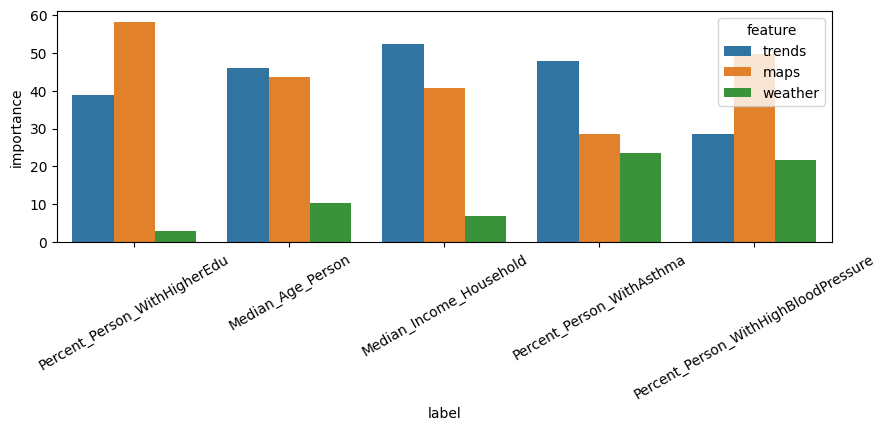

In [ ]:
#@title LightGBM feature importance
import seaborn as sns
features = {
  'trends': (128, embedding_features[:128]),
  'maps': (128, embedding_features[128:256]),
  'weather': (74, embedding_features[256:]),
}
all_importance = []
for label, model in models_by_label_lgbm.items():
  importance = pd.DataFrame(model[1].feature_importances_,
                            index=embedding_features,
                            columns=['importance'])
  importance['importance'] = importance['importance'].abs()
  for feature, dims in features.items():
    importance.loc[dims[1], 'feature'] = feature
  importance = importance.groupby('feature').importance.sum().reset_index()
  importance['importance'] = (importance.importance /
                              importance.importance.sum() * 100)
  importance['label'] = label
  all_importance.append(importance)
all_importance = pd.concat(all_importance)
_, ax = plt.subplots(figsize=(10, 3))
sns.barplot(data=all_importance, x='label', y='importance',
            hue='feature',
            hue_order=features.keys(), ax=ax)
_ = plt.xticks(rotation=30)